## 🚀 Google Colab Setup

**Run these commands in Colab before running the notebook:**

'''
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/projects/auto-labeling
'''

In [12]:
# from google.colab import drive
# drive.mount('/content/drive')
# %cd /content/drive/MyDrive/projects/auto-labeling

# Install package in development mode
!pip install -e .

Obtaining file:///C:/Users/abc/Documents/auto-labeling
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Attempting uninstall: auto-labeling
    Found existing installation: auto-labeling 0.1.0
    Uninstalling auto-labeling-0.1.0:
      Successfully uninstalled auto-labeling-0.1.0
  Running setup.py develop for auto-labeling


  DEPRECATION: Legacy editable install of auto-labeling==0.1.0 from file:///C:/Users/abc/Documents/auto-labeling (setup.py develop) is deprecated. pip 25.3 will enforce this behaviour change. A possible replacement is to add a pyproject.toml or enable --use-pep517, and use setuptools >= 64. If the resulting installation is not behaving as expected, try using --config-settings editable_mode=compat. Please consult the setuptools documentation for more information. Discussion can be found at https://github.com/pypa/pip/issues/11457


# Active Learning Training Pipeline

This notebook implements **pseudo-labeling with active learning** for lung cancer survival prediction.

## Two Approaches:
1. **Combined**: Randomly select labeled ratio from both train and test sets combined
2. **Train Only**: Apply active learning on training set, evaluate on separate test set

## Key Features:
- Progressive confidence threshold (starts low, increases over epochs)
- Entropy-based confidence scoring
- Imbalance handling applied only to initial labeled data
- Parallel training across all models × imbalance methods
- Comprehensive metrics tracking per epoch

## 1. Import Libraries

In [2]:
import yaml
import numpy as np
import pandas as pd
from datetime import datetime
import os
import sys
from pathlib import Path
import time
from joblib import Parallel, delayed
import matplotlib.pyplot as plt
import seaborn as sns

# Import custom modules
from datasets import DatasetFactory
from modules.imbalance_handler import ImbalanceHandler
from modules.models import ModelFactory
from modules.trainer import Trainer
from modules.evaluator import Evaluator
from modules.visualizer import Visualizer
from modules.active_learning import (
    active_learning_cycle,
    split_data_combined,
    split_data_train_only
)

print("✓ All libraries imported successfully")

✓ All libraries imported successfully


## 2. Load Configuration

In [3]:
# Load configuration
with open('config.yaml', 'r') as f:
    config = yaml.safe_load(f)

# Extract settings
RANDOM_SEED = config['random_seed']
np.random.seed(RANDOM_SEED)

# Active learning parameters
al_config = config['active_learning']
APPROACH = al_config['approach']  # "combined" or "train_only"
LABELED_RATIO = al_config['labeled_ratio']
VALIDATION_RATIO = al_config['validation_ratio']
CONFIDENCE_THRESHOLD = al_config['confidence_threshold']
USE_DYNAMIC_THRESHOLD = al_config['use_dynamic_threshold']
TAU_MIN = al_config['tau_min']
TAU_MAX = al_config['tau_max']
N_ACTIVE_LEARNING_EPOCHS = al_config['max_epochs']
APPLY_IMBALANCE_TO_INITIAL = al_config['apply_imbalance_to_initial']

# Model and imbalance settings
ACTIVE_MODELS = config['models']['active']
IMBALANCE_METHODS = config['imbalance']['methods']
N_WORKERS = config['training']['n_workers']

print("Configuration loaded:")
print(f"  Approach: {APPROACH}")
print(f"  Labeled Ratio: {LABELED_RATIO:.1%}")
print(f"  Validation Ratio: {VALIDATION_RATIO:.1%}")
print(f"  Confidence Threshold: {CONFIDENCE_THRESHOLD} (Dynamic: {USE_DYNAMIC_THRESHOLD})")
print(f"  Max Epochs: {N_ACTIVE_LEARNING_EPOCHS}")
print(f"  Models: {len(ACTIVE_MODELS)}")
print(f"  Imbalance Methods: {len(IMBALANCE_METHODS)}")
print(f"  Parallel Workers: {N_WORKERS}")

Configuration loaded:
  Approach: combined
  Labeled Ratio: 10.0%
  Validation Ratio: 20.0%
  Confidence Threshold: 0.9 (Dynamic: False)
  Max Epochs: 20
  Models: 4
  Imbalance Methods: 3
  Parallel Workers: 4


## 3. Load Dataset and Split Data

In [4]:
# Load dataset from config
dataset_name = config['dataset']['name']
dataset, X_train_orig, y_train_orig, X_test_orig, y_test_orig, dataset_info = \
    DatasetFactory.load_dataset(dataset_name)

print(f"Dataset: {dataset_info['name']}")
print(f"  Description: {dataset_info['description']}")
print(f"  Task Type: {dataset_info['task_type']}")
print(f"  Original Train: {X_train_orig.shape}")
print(f"  Original Test: {X_test_orig.shape}")
print()

# Convert to numpy arrays
X_train_orig = X_train_orig.values
y_train_orig = y_train_orig.values
X_test_orig = X_test_orig.values
y_test_orig = y_test_orig.values

# Split data based on approach
if APPROACH == "combined":
    print(f"=== Approach 1: Combined Dataset Split ===")
    X_labeled, y_labeled, X_val, y_val, X_unlabeled, y_unlabeled = split_data_combined(
        X_train_orig, y_train_orig, X_test_orig, y_test_orig,
        labeled_ratio=LABELED_RATIO,
        validation_ratio=VALIDATION_RATIO,
        random_state=RANDOM_SEED
    )
    X_test_final = None
    y_test_final = None

    print(f"  Initial Labeled: {X_labeled.shape[0]} samples")
    print(f"  Validation: {X_val.shape[0]} samples")
    print(f"  Unlabeled Pool: {X_unlabeled.shape[0]} samples")
    print(f"  (No separate test set - unlabeled pool serves as test data)")

elif APPROACH == "train_only":
    print(f"=== Approach 2: Train-Only Split ===")
    X_labeled, y_labeled, X_val, y_val, X_unlabeled, y_unlabeled, X_test_final, y_test_final = split_data_train_only(
        X_train_orig, y_train_orig, X_test_orig, y_test_orig,
        labeled_ratio=LABELED_RATIO,
        validation_ratio=VALIDATION_RATIO,
        random_state=RANDOM_SEED
    )

    print(f"  Initial Labeled: {X_labeled.shape[0]} samples")
    print(f"  Validation: {X_val.shape[0]} samples")
    print(f"  Unlabeled Pool: {X_unlabeled.shape[0]} samples")
    print(f"  Final Test Set: {X_test_final.shape[0]} samples")
else:
    raise ValueError(f"Unknown approach: {APPROACH}")

print(f"\nClass distribution in initial labeled data: {np.bincount(y_labeled.astype(int))}")

Dataset: lung_cancer
  Description: Lung cancer 2-year survival prediction from index_age
  Task Type: binary
  Original Train: (19000, 52)
  Original Test: (11444, 52)

=== Approach 1: Combined Dataset Split ===
  Initial Labeled: 2436 samples
  Validation: 608 samples
  Unlabeled Pool: 27400 samples
  (No separate test set - unlabeled pool serves as test data)

Class distribution in initial labeled data: [ 852 1584]


## 4. Define Training Job Function

In [5]:
def train_active_learning_job(model_name, imbalance_method,
                               X_labeled_init, y_labeled_init,
                               X_val, y_val,
                               X_unlabeled, y_unlabeled,
                               X_test_final, y_test_final,
                               config):
    """
    Train a single model using active learning with pseudo-labeling

    Returns:
        Dictionary with model name, imbalance method, metrics history, and final results
    """
    job_start = time.time()

    # Copy data to avoid modifying originals
    X_labeled = X_labeled_init.copy()
    y_labeled = y_labeled_init.copy()
    X_unlab = X_unlabeled.copy()
    y_unlab = y_unlabeled.copy()

    # Apply imbalance handling to initial labeled data
    if imbalance_method != "none" and APPLY_IMBALANCE_TO_INITIAL:
        imbalance_handler = ImbalanceHandler(imbalance_method, random_state=RANDOM_SEED)
        X_labeled, y_labeled = imbalance_handler.apply(
            X_labeled, y_labeled,
            task_type=dataset_info['task_type']
        )

    # Create and train initial model
    model = ModelFactory.create_model(model_name)
    trainer = Trainer(model, model_name)

    # Train initial model
    trainer.train(X_labeled, y_labeled)

    # Track metrics per epoch
    metrics_history = []

    # Active learning loop using the module's implementation
    for epoch in range(1, N_ACTIVE_LEARNING_EPOCHS + 1):
        # Use active_learning_cycle from module
        model, X_labeled, y_labeled, X_unlab, y_unlab, metrics = active_learning_cycle(
            model=trainer.model,
            X_labeled=X_labeled,
            y_labeled=y_labeled,
            X_unlabeled=X_unlab,
            y_unlabeled=y_unlab,
            X_val=X_val,
            y_val=y_val,
            epoch=epoch,
            total_epochs=N_ACTIVE_LEARNING_EPOCHS,
            use_dynamic_threshold=USE_DYNAMIC_THRESHOLD,
            confidence_threshold=CONFIDENCE_THRESHOLD,
            tau_min=TAU_MIN,
            tau_max=TAU_MAX,
            verbose=False
        )

        # Update trainer with new model
        trainer.model = model

        # Evaluate on validation set for consistent metrics
        y_val_proba_raw = model.predict_proba(X_val)

        # For binary classification, extract positive class probabilities
        if dataset_info['task_type'] == 'binary' and y_val_proba_raw.ndim == 2:
            y_val_proba = y_val_proba_raw[:, 1]  # Positive class
        else:
            y_val_proba = y_val_proba_raw

        evaluator = Evaluator(task_type=dataset_info['task_type'])
        val_results = evaluator.evaluate_model(
            y_val, y_val_proba, model_name, imbalance_method, 0.0
        )
        val_metrics = val_results[0]

        # Store metrics
        metrics_history.append({
            'epoch': epoch,
            'threshold': metrics['threshold'],
            'pseudo_labeled': metrics['pseudo_labeled'],
            'labeled_size': len(y_labeled),
            'unlabeled_size': metrics['unlabeled_remaining'],
            'accuracy': val_metrics['accuracy'],
            'auc': val_metrics.get('auc', 0.0),
            'f1': val_metrics.get('f1', 0.0),
            'sensitivity': val_metrics.get('sensitivity', 0.0),
            'specificity': val_metrics.get('specificity', 0.0),
            'train_acc': metrics['train_acc'],
            'val_acc': metrics['val_acc'],
            'train_loss': metrics['train_loss'],
            'val_loss': metrics['val_loss']
        })

        # Break if no more unlabeled data
        if len(X_unlab) == 0:
            break

    # Final evaluation on test set
    if X_test_final is not None and y_test_final is not None:
        y_test_proba_raw = trainer.model.predict_proba(X_test_final)

        # For binary classification, extract positive class probabilities
        if dataset_info['task_type'] == 'binary' and y_test_proba_raw.ndim == 2:
            y_test_proba = y_test_proba_raw[:, 1]
        else:
            y_test_proba = y_test_proba_raw

        evaluator = Evaluator(task_type=dataset_info['task_type'])
        final_results_list = evaluator.evaluate_model(
            y_test_final, y_test_proba, model_name, imbalance_method, 0.0
        )
        final_metrics = final_results_list[0]
        eval_set = 'test'
    else:
        # Use validation set as final evaluation
        final_metrics = val_metrics
        eval_set = 'validation'

    job_time = time.time() - job_start

    return {
        'model_name': model_name,
        'imbalance_method': imbalance_method,
        'metrics_history': metrics_history,
        'final_metrics': final_metrics,
        'training_time': job_time,
        'total_epochs': len(metrics_history),
        'final_labeled_size': len(y_labeled),
        'eval_set': eval_set
    }

## 5. Run Parallel Active Learning Training

In [6]:
# Create job list
jobs = [
    (model_name, imbalance_method)
    for model_name in ACTIVE_MODELS
    for imbalance_method in IMBALANCE_METHODS
]

print(f"Starting {len(jobs)} active learning training jobs with {N_WORKERS} workers...")
print(f"Models: {ACTIVE_MODELS}")
print(f"Imbalance Methods: {IMBALANCE_METHODS}")
print()

# Run parallel training
training_start = time.time()

results = Parallel(n_jobs=N_WORKERS, verbose=10)(
    delayed(train_active_learning_job)(
        model_name, imbalance_method,
        X_labeled, y_labeled,
        X_val, y_val,
        X_unlabeled, y_unlabeled,
        X_test_final, y_test_final,
        config
    )
    for model_name, imbalance_method in jobs
)

total_training_time = time.time() - training_start

print(f"\n{'='*60}")
print(f"✓ All {len(results)} jobs completed in {total_training_time:.2f}s")
print(f"{'='*60}")

Starting 12 active learning training jobs with 4 workers...
Models: ['logistic_regression', 'random_forest', 'xgboost', 'lightgbm']
Imbalance Methods: ['none', 'smote', 'adasyn']



[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:  3.0min
[Parallel(n_jobs=4)]: Done   7 out of  12 | elapsed:  4.1min remaining:  2.9min
[Parallel(n_jobs=4)]: Done   9 out of  12 | elapsed:  5.7min remaining:  1.9min
[Parallel(n_jobs=4)]: Done  12 out of  12 | elapsed:  7.3min finished



✓ All 12 jobs completed in 437.46s


## 6. Organize Results

In [7]:
# Create summary DataFrame
summary_data = []
for result in results:
    summary_data.append({
        'model': result['model_name'],
        'imbalance': result['imbalance_method'],
        'final_accuracy': result['final_metrics']['accuracy'],
        'final_auc': result['final_metrics'].get('auc', 0.0),
        'final_f1': result['final_metrics'].get('f1', 0.0),
        'final_weighted_f1': result['final_metrics'].get('weighted_f1', 0.0),
        'final_macro_f1': result['final_metrics'].get('macro_f1', 0.0),
        'training_time': result['training_time'],
        'total_epochs': result['total_epochs'],
        'final_labeled_size': result['final_labeled_size'],
        'eval_set': result['eval_set']
    })

summary_df = pd.DataFrame(summary_data)
summary_df = summary_df.sort_values('final_auc', ascending=False)

print("All trained models:")
print(summary_df.to_string(index=False))
print()

All trained models:
              model imbalance  final_accuracy  final_auc  final_f1  final_weighted_f1  final_macro_f1  training_time  total_epochs  final_labeled_size   eval_set
      random_forest      none        0.983553   0.997047  0.987745           0.983553        0.981373     202.249691            20               11542 validation
      random_forest     smote        0.981908   0.996599  0.986536           0.981896        0.979484     233.721713            20               12752 validation
      random_forest    adasyn        0.985197   0.996385  0.988957           0.985207        0.983257     233.324054            20               12448 validation
            xgboost      none        0.970395   0.985282  0.978102           0.970277        0.966208      42.739807            20               15133 validation
            xgboost    adasyn        0.963816   0.980208  0.973171           0.963721        0.958808     229.527287            20               15622 validation
        

## 7. Save Results

In [8]:
# Create results directory
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
results_dir = f"results/active_learning_{APPROACH}_{timestamp}"
os.makedirs(results_dir, exist_ok=True)

# Save summary
summary_df.to_csv(f"{results_dir}/summary.csv", index=False)
print(f"✓ Summary saved to {results_dir}/summary.csv")

# Save detailed metrics history for each model
for result in results:
    model_name = result['model_name']
    imbalance = result['imbalance_method']
    filename = f"{results_dir}/history_{model_name}_{imbalance}.csv"
    history_df = pd.DataFrame(result['metrics_history'])
    history_df.to_csv(filename, index=False)

print(f"✓ {len(results)} detailed history files saved")

# Save experiment configuration
config_summary = {
    'approach': APPROACH,
    'labeled_ratio': LABELED_RATIO,
    'validation_ratio': VALIDATION_RATIO,
    'confidence_threshold': CONFIDENCE_THRESHOLD,
    'use_dynamic_threshold': USE_DYNAMIC_THRESHOLD,
    'tau_min': TAU_MIN,
    'tau_max': TAU_MAX,
    'max_epochs': N_ACTIVE_LEARNING_EPOCHS,
    'initial_labeled': len(X_labeled),
    'validation_size': len(X_val),
    'unlabeled_pool': len(X_unlabeled),
    'test_size': len(X_test_final) if X_test_final is not None else 0,
    'total_training_time': total_training_time,
    'n_models': len(ACTIVE_MODELS),
    'n_imbalance_methods': len(IMBALANCE_METHODS),
    'n_workers': N_WORKERS
}

with open(f"{results_dir}/config_summary.yaml", 'w') as f:
    yaml.dump(config_summary, f, default_flow_style=False)

print(f"✓ Configuration saved to {results_dir}/config_summary.yaml")
print()
print(f"All results saved to: {results_dir}/")

✓ Summary saved to results/active_learning_combined_20260206_224948/summary.csv
✓ 12 detailed history files saved
✓ Configuration saved to results/active_learning_combined_20260206_224948/config_summary.yaml

All results saved to: results/active_learning_combined_20260206_224948/


## 8. Visualize Learning Curves

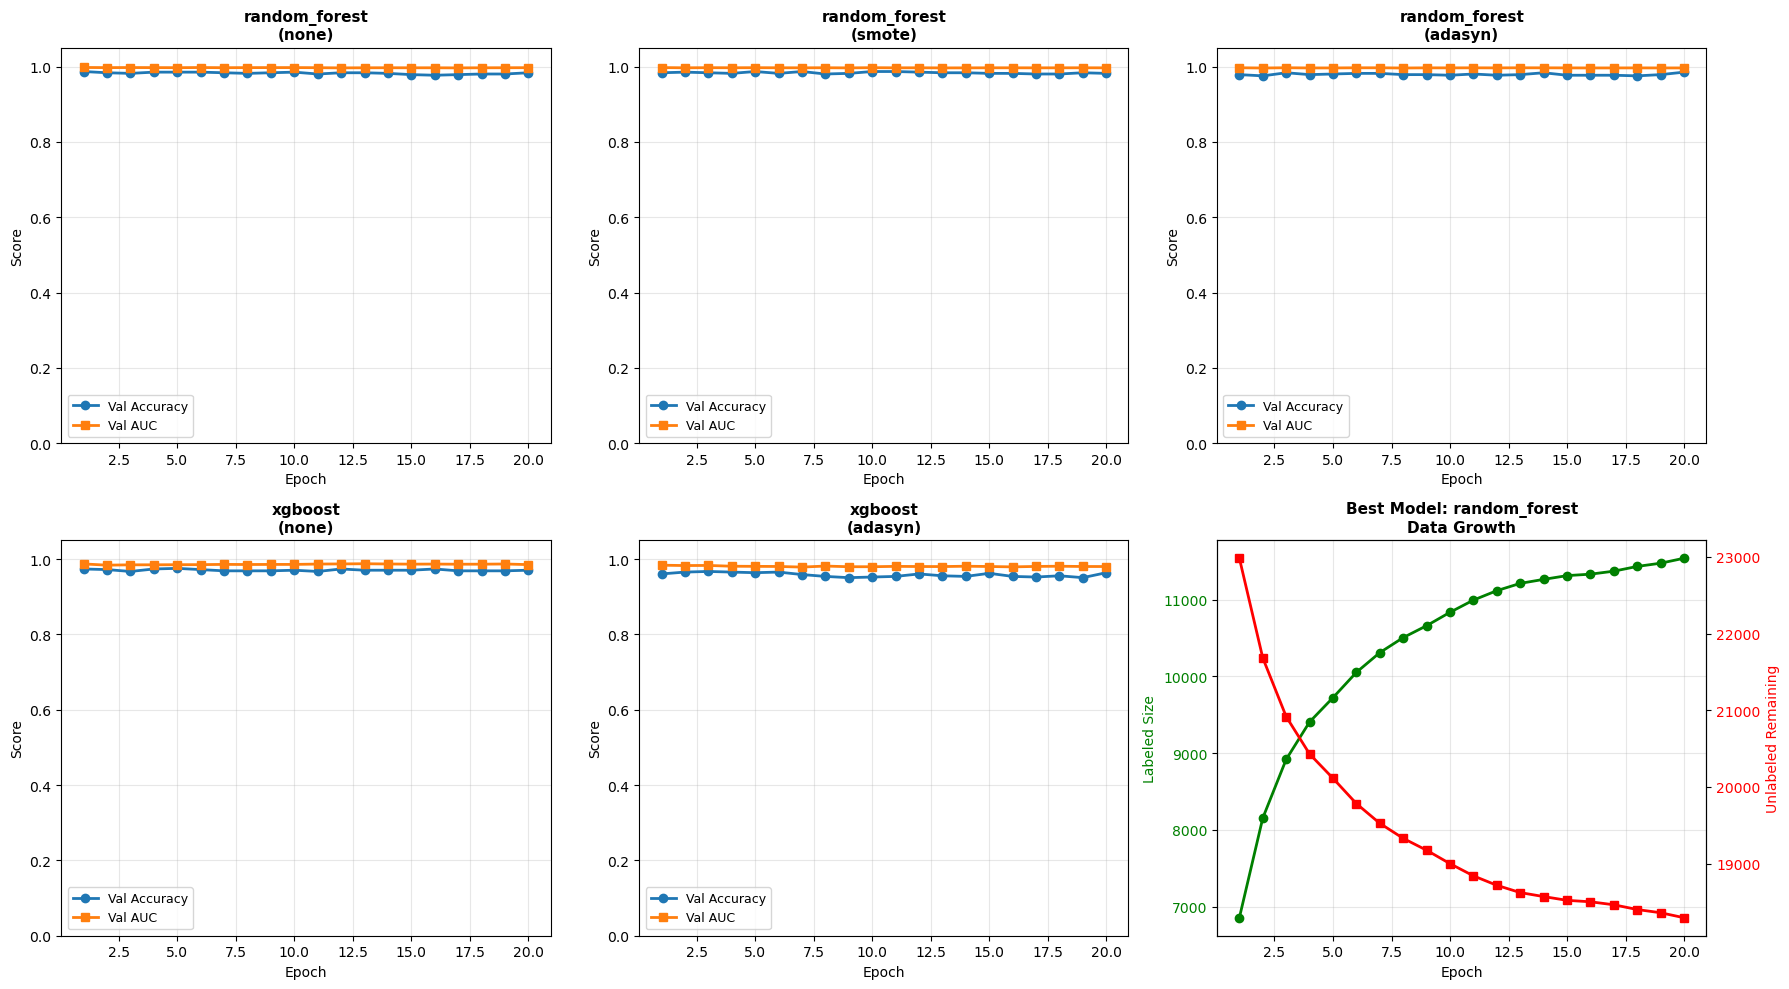

✓ Learning curves plotted


In [9]:
# Plot learning curves for top 5 models
top_5_indices = summary_df.head(5).index

fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.flatten()

for idx, result_idx in enumerate(top_5_indices):
    result = results[result_idx]
    history_df = pd.DataFrame(result['metrics_history'])

    ax = axes[idx]

    # Plot validation accuracy and AUC
    ax.plot(history_df['epoch'], history_df['accuracy'], marker='o', label='Val Accuracy', linewidth=2)
    ax.plot(history_df['epoch'], history_df['auc'], marker='s', label='Val AUC', linewidth=2)

    ax.set_xlabel('Epoch', fontsize=10)
    ax.set_ylabel('Score', fontsize=10)
    ax.set_title(f"{result['model_name']}\n({result['imbalance_method']})", fontsize=11, fontweight='bold')
    ax.legend(fontsize=9)
    ax.grid(True, alpha=0.3)
    ax.set_ylim([0, 1.05])

# Plot pseudo-label growth for best model
best_result = results[summary_df.index[0]]
best_history_df = pd.DataFrame(best_result['metrics_history'])

ax = axes[5]
ax2 = ax.twinx()

# Labeled size
ax.plot(best_history_df['epoch'], best_history_df['labeled_size'],
        marker='o', color='green', linewidth=2, label='Labeled Size')
ax.set_xlabel('Epoch', fontsize=10)
ax.set_ylabel('Labeled Size', fontsize=10, color='green')
ax.tick_params(axis='y', labelcolor='green')

# Unlabeled remaining
ax2.plot(best_history_df['epoch'], best_history_df['unlabeled_size'],
         marker='s', color='red', linewidth=2, label='Unlabeled Remaining')
ax2.set_ylabel('Unlabeled Remaining', fontsize=10, color='red')
ax2.tick_params(axis='y', labelcolor='red')

ax.set_title(f"Best Model: {best_result['model_name']}\nData Growth",
             fontsize=11, fontweight='bold')
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("✓ Learning curves plotted")

## 9. Summary Report

In [10]:
print("="*70)
print(" ACTIVE LEARNING TRAINING SUMMARY")
print("="*70)
print()
print(f"Approach: {APPROACH}")
print(f"  - {'Combined train+test split' if APPROACH == 'combined' else 'Train-only split with separate test set'}")
print()
print(f"Dataset Configuration:")
print(f"  Initial Labeled: {len(X_labeled)} samples ({LABELED_RATIO:.1%})")
print(f"  Validation: {len(X_val)} samples ({VALIDATION_RATIO:.1%} of labeled)")
print(f"  Unlabeled Pool: {len(X_unlabeled)} samples")
if X_test_final is not None:
    print(f"  Final Test Set: {len(X_test_final)} samples")
print()
print(f"Active Learning Configuration:")
print(f"  Max Epochs: {N_ACTIVE_LEARNING_EPOCHS}")
print(f"  Dynamic Threshold: {USE_DYNAMIC_THRESHOLD}")
if USE_DYNAMIC_THRESHOLD:
    print(f"    - Range: {TAU_MIN:.2f} → {TAU_MAX:.2f}")
else:
    print(f"    - Static: {CONFIDENCE_THRESHOLD:.2f}")
print(f"  Imbalance on Initial: {APPLY_IMBALANCE_TO_INITIAL}")
print()
print(f"Training Configuration:")
print(f"  Models Tested: {len(ACTIVE_MODELS)}")
print(f"  Imbalance Methods: {len(IMBALANCE_METHODS)}")
print(f"  Total Jobs: {len(results)}")
print(f"  Parallel Workers: {N_WORKERS}")
print(f"  Total Training Time: {total_training_time:.2f}s ({total_training_time/60:.1f}m)")
print()
print(f"Top 5 Models:")
for i, (idx, row) in enumerate(summary_df.head(5).iterrows(), 1):
    result = results[idx]
    print(f"  {i}. {row['model']:20s} + {row['imbalance']:15s} | "
          f"AUC: {row['final_auc']:.4f} | Acc: {row['final_accuracy']:.4f} | "
          f"F1: {row['final_f1']:.4f} | Time: {row['training_time']:.1f}s")
print()
print(f"Best Model Details:")
best_result = results[summary_df.index[0]]
print(f"  Model: {best_result['model_name']}")
print(f"  Imbalance Method: {best_result['imbalance_method']}")
print(f"  Final Metrics (on {best_result['eval_set']} set):")
for metric, value in best_result['final_metrics'].items():
    if isinstance(value, (int, float)):
        print(f"    - {metric}: {value:.4f}")
print(f"  Training Statistics:")
print(f"    - Total Epochs: {best_result['total_epochs']}")
print(f"    - Final Labeled Size: {best_result['final_labeled_size']}")
print(f"    - Training Time: {best_result['training_time']:.2f}s")
print()
print(f"Results saved to: {results_dir}/")
print("="*70)

 ACTIVE LEARNING TRAINING SUMMARY

Approach: combined
  - Combined train+test split

Dataset Configuration:
  Initial Labeled: 2436 samples (10.0%)
  Validation: 608 samples (20.0% of labeled)
  Unlabeled Pool: 27400 samples

Active Learning Configuration:
  Max Epochs: 20
  Dynamic Threshold: False
    - Static: 0.90
  Imbalance on Initial: True

Training Configuration:
  Models Tested: 4
  Imbalance Methods: 3
  Total Jobs: 12
  Parallel Workers: 4
  Total Training Time: 437.46s (7.3m)

Top 5 Models:
  1. random_forest        + none            | AUC: 0.9970 | Acc: 0.9836 | F1: 0.9877 | Time: 202.2s
  2. random_forest        + smote           | AUC: 0.9966 | Acc: 0.9819 | F1: 0.9865 | Time: 233.7s
  3. random_forest        + adasyn          | AUC: 0.9964 | Acc: 0.9852 | F1: 0.9890 | Time: 233.3s
  4. xgboost              + none            | AUC: 0.9853 | Acc: 0.9704 | F1: 0.9781 | Time: 42.7s
  5. xgboost              + adasyn          | AUC: 0.9802 | Acc: 0.9638 | F1: 0.9732 | Time: 